The goal of this notebook is to develop an end2end text classifier using different embedding like word2vec, fasttext, and doc2vec.

The first pipe is to clean the text data (More cleaning for future data.) 

In [1]:


# Data cleaning
# ===========================================================================
import re
def clean_text(text):
    # replace  . and a space with only a space, then amke all words lower case.
    text = text.replace(". "," ").replace(",","").lower()
    # get rid of the . at the end of each line. 
    cleaned_text = re.sub("\.$","",text)
    
    return cleaned_text
 


class text_clean:
    """
    A class to help with cleaning text data. 
    """
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        assert isinstance(X,pd.Series), "The input data should be pandas Series."
        X = X.apply(clean_text)
        
        return X


# Word embedding training 
# ===========================================================================
from tqdm import tqdm
import numpy as np
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.externals import joblib

from sklearn.base import BaseEstimator

def _find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    
    return part_pii    



def _extracted_pii2matrix(pii_list, model):
    # set the matrix dimensions
    column_num = model.trainables.layer1_size
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat



class word_embedding(BaseEstimator):
    """
    A class to convert words/docs to vectors by applying any model supported by gensim.  
    
    This class will allow continued training on the pre-trained model by assigning
    the model to the pre_trained option in class initialization.  
    
    After training the model, it will dump the word2vec model to the path assigned to 
    dump_file option.  
    
    
    """
    def __init__(self, algo_name = "word2vec", size = 100, min_count = 1, window = 5, workers =1,\
                 epochs = 5, pre_train = None, dump_file = False, continue_train_pre_train = True,
                 re_train_new_sentences = True):
        
        
        assert algo_name in ["word2vec", 'fasttext', 'doc2vec'], \
        "please enter a model name in ['word2vec', 'fasttext', 'doc2vec']"
        
        self.algo_name = algo_name
        self.epochs = epochs 
        self.pre_train = pre_train
        self.dump_file = dump_file 
        self.re_train_new_sentences = re_train_new_sentences
        self.continue_train_pre_train = continue_train_pre_train
        
        # model options
        self.size = size
        self.min_count = min_count
        self.window = window
        self.workers = workers
        
        
    def _algo_init(self):
        if self.algo_name == "word2vec":
            model = Word2Vec(size = self.size, min_count = self.min_count,
                            window = self.window, workers = self.workers)
        elif self.algo_name == "fasttext":
            model = FastText(size = self.size, min_count = self.min_count,
                            window = self.window, workers = self.workers)
        elif self.algo_name == "doc2vec":
            model = Doc2Vec(vector_size = self.size, min_count = self.min_count,
                            window = self.window, workers = self.workers)
            
        self.model = model
        return self

    def _embedding_training(self, sentences, update = False):
        """
        This helper functions will build the vocabulary, train the model and update the self.model
        with the newly trained model.
        
        if update = True, it will update the vocabulary and the model can continue to train.
        If update = False, the model will rebuild a new vocabulary from scratch using the input data.
        """
        updated_model_with_vocab = self.model

        updated_model_with_vocab.build_vocab(sentences, update = update)
        
        updated_model_with_vocab.train(sentences, total_examples = len(sentences), epochs = self.epochs)
        
        # update the model with the trained one. 
        self.model = updated_model_with_vocab
        
    def _pd_to_gensim_format(self, text):
        
        # special handling for doc2vec model. 
        if self.algo_name == "doc2vec":
            documents = [TaggedDocument(sentence.split(" "), [index])\
                          for index, sentence in enumerate(text)] 
            print("Using index for the tags")    
        else:
            documents = [sentence.split(" ") for sentence in text]
            
            
        return documents
            
        
    def fit(self, X, y = None):
        """
        The fit method will get use the pre_trained model if the model is assigned to the pre_train option.
        
        If the pre_train is None, then the model will be trained. 
        
        
        If the pre_train model is not None, then the default is to continue training on the new model. 
        Unless option continue_train_pre_train is specified as False. The False option will just assign 
        the pre_train model to self.model
        """
        gensim_X = self._pd_to_gensim_format(text = X)
        
        if self.pre_train is not None:
            
            # update the pre_trained model with new training data
            if self.continue_train_pre_train:
                self.model = self.pre_train
                self._embedding_training(sentences = gensim_X, update = True)
                print("continue training with the pre_train model.")
                
            # no training the pre_trained model. 
            elif not self.continue_train_pre_train:
                self.model = self.pre_train
                print("No training with pre_train model.")
                
            
            return self
        
        else:
            # initialize the model, split the sentence into tokens and train it. 
            self._algo_init()
            self._embedding_training(sentences = gensim_X)
            print("Building new vocabulary and training the {} model".format(self.algo_name))
        
        
        # dump the model to disk
        if isinstance(self.dump_file,str):
            self.model.save(self.dump_file)
            print("Writing the {} model to disk.".format(self.algo_name))
            
        return self
        
    
    def transform(self, X):
        """
        If re_train_new_sentences is True, which is the default setting, 
        the model will be re-trained on the new sentences. 
        This will create word embedding for words not in the original vocabulary.
        This will increase the model inference time since it invovles model training. 
        
        For using word2vec to predict PII data, it is recommended to update the model with new sentences. 
        For fastttext, it is not necessary since it will infer from the character n-grams. The fasttext training
        is much longer than word2vec. 
        """
        gensim_X = self._pd_to_gensim_format(text = X)
        
        # update the embedding with new sentences or train the model. 
        if self.re_train_new_sentences:
            self._embedding_training(sentences = gensim_X, update = True)
            print("transforming while training {} model with new data.".format(self.algo_name))
            
            
        # extract the PII 
        extracted_pii_list = [_find_part_pii(text = text, model = self.model)\
                    for text in tqdm(X) ]
        
        # convert the extracted pii text into vectors.
        piivec_matrix = _extracted_pii2matrix(pii_list = extracted_pii_list,\
                                          model = self.model)
        return piivec_matrix 
                                          

In [2]:
import pandas as pd
algo_test_data = pd.read_csv("../data/train_text_with_pii_2019_01_05_02_48_24_796403.csv")

## Word2vec testing

In [3]:
testing_embedding = word_embedding(algo_name = 'word2vec', dump_file = './devs/word2vec.bin')
testing_embedding.fit(algo_test_data['Text']);
test_pii_matrix = testing_embedding.transform(algo_test_data["Text"])
test_pii_matrix.shape

  0%|          | 0/800 [00:00<?, ?it/s]

Building new vocabulary and training the word2vec model
Writing the word2vec model to disk.
transforming while training word2vec model with new data.


100%|██████████| 800/800 [00:00<00:00, 185753.06it/s]


(800, 100)

In [4]:
pre_trained1 = Word2Vec.load("./word2vec/word2vec_cleaned_300_.bin")
pre_trained2 = Word2Vec.load("./devs/word2vec.bin")
testing_pre_trained = word_embedding(algo_name = "word2vec", pre_train = pre_trained2)
testing_pre_trained.fit(algo_test_data["Text"])
test_pii_matrix = testing_pre_trained.transform(algo_test_data["Text"])
test_pii_matrix.shape

100%|██████████| 800/800 [00:00<00:00, 186185.95it/s]

continue training with the pre_train model.
transforming while training word2vec model with new data.


(800, 100)

## Fasttext testing

In [5]:
testing_embedding = word_embedding(algo_name = 'fasttext', dump_file = "./devs/fasttext.bin")

testing_embedding.fit(algo_test_data["Text"]);
test_pii_matrix = testing_embedding.transform(algo_test_data["Text"])
test_pii_matrix.shape

Building new vocabulary and training the fasttext model
Writing the fasttext model to disk.


100%|██████████| 800/800 [00:00<00:00, 131529.27it/s]

transforming while training fasttext model with new data.


(800, 100)

In [6]:
pre_trained = FastText.load("./devs/fasttext.bin")
testing_pre_trained = word_embedding(algo_name = "fasttext", pre_train = pre_trained)
testing_pre_trained.fit(algo_test_data["Text"])
test_pii_matrix = testing_pre_trained.transform(algo_test_data["Text"])
test_pii_matrix.shape

continue training with the pre_train model.


100%|██████████| 800/800 [00:00<00:00, 154857.08it/s]

transforming while training fasttext model with new data.


(800, 100)

## doc2vec testing

In [7]:
testing_embedding_doc2vec = word_embedding(algo_name = 'doc2vec', dump_file = "./devs/doc2vec.bin")
testing_embedding_doc2vec.fit(X = algo_test_data['Text'])

test__doc2vec_pii_matrix = testing_embedding_doc2vec.transform(algo_test_data['Text'])
test__doc2vec_pii_matrix.shape

Using index for the tags


  0%|          | 0/800 [00:00<?, ?it/s]

Building new vocabulary and training the doc2vec model
Writing the doc2vec model to disk.
Using index for the tags
transforming while training doc2vec model with new data.


100%|██████████| 800/800 [00:00<00:00, 210451.78it/s]


(800, 100)

In [8]:
pre_trained = FastText.load("./devs/doc2vec.bin")
testing_pre_trained = word_embedding(algo_name = "doc2vec", pre_train = pre_trained)
testing_pre_trained.fit(algo_test_data["Text"])
test_pii_matrix = testing_pre_trained.transform(algo_test_data["Text"])
test_pii_matrix.shape

Using index for the tags
continue training with the pre_train model.
Using index for the tags


100%|██████████| 800/800 [00:00<00:00, 199538.73it/s]

transforming while training doc2vec model with new data.


(800, 100)

## Add all the pipe above to a single pipeline for training an end-to-end model.

## word2vec pipe

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
logit_clf = LogisticRegression(solver = "lbfgs", max_iter = 10000, class_weight={0:0.9,1:0.1})

In [10]:
word2vec_pipe = Pipeline([('text_cleaning', text_clean()),
                 ("fasttext", word_embedding(algo_name = "word2vec", size= 100,\
                                             dump_file = "./word2vec/word2vec_100_pipe_dump.bin")),
                 ("logit",logit_clf)
                ])

In [11]:
pipe_test_data = pd.read_csv("../clean_data/Cleaned_test_text_with_pii_2018_12_31_05_35_46_815414.csv")

In [12]:
pipe_test_data.head()

,Text,Labels,PII,Cleaned_text,Target
0,Wife marriage cup 7416 Smith Forks before pict...,Address,7416 Smith Forks,wife marriage cup 7416 smith forks before pict...,1
1,However send which. Suite 244 Nice market acce...,Address,Suite 244,however send which suite 244 nice market accep...,1
2,0497 Kemp Lane Amount tough and fire until. Is...,Address,0497 Kemp Lane,0497 kemp lane amount tough and fire until iss...,1
3,Model north receive nature effort 58162 France...,Address,"58162 Frances Shoals Conniemouth, OH 71686",model north receive nature effort 58162 france...,1
4,Child already drive could. Begin such down cel...,Address,538 Gina Circles,child already drive could begin such down cell...,1


In [13]:
%%time 
word2vec_pipe.fit(pipe_test_data["Text"],pipe_test_data['Target'] )

Building new vocabulary and training the word2vec model
Writing the word2vec model to disk.


  1%|          | 730/80000 [00:00<00:10, 7295.33it/s]

transforming while training word2vec model with new data.


100%|██████████| 80000/80000 [00:00<00:00, 273495.78it/s]


CPU times: user 37.3 s, sys: 5.24 s, total: 42.5 s
Wall time: 34.6 s


Pipeline(memory=None,
     steps=[('text_cleaning', <__main__.text_clean object at 0x7f7983150be0>), ('fasttext', word_embedding(algo_name='word2vec', continue_train_pre_train=True,
        dump_file='./word2vec/word2vec_100_pipe_dump.bin', epochs=5,
        min_count=1, pre_train=None, re_train_new_sentences=True, size=100,
...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

## fasttext pipe

In [14]:
logit_clf = LogisticRegression(solver = "lbfgs", max_iter = 10000, class_weight={0:0.9,1:0.1})
fasttext_pipe = Pipeline([('text_cleaning', text_clean()),
                 ("fasttext", word_embedding(algo_name = "fasttext", size= 100,\
                                             dump_file = "./fasttext/fasttext_100_pipe_dump.bin")),
                 ("logit",logit_clf)
                ])

In [15]:
%%time 
fasttext_pipe.fit(pipe_test_data["Text"],pipe_test_data['Target'] )

Building new vocabulary and training the fasttext model
Writing the fasttext model to disk.


  0%|          | 0/80000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 80000/80000 [00:00<00:00, 237005.16it/s]


CPU times: user 1min 46s, sys: 8.38 s, total: 1min 55s
Wall time: 1min 39s


Pipeline(memory=None,
     steps=[('text_cleaning', <__main__.text_clean object at 0x7f797853d748>), ('fasttext', word_embedding(algo_name='fasttext', continue_train_pre_train=True,
        dump_file='./fasttext/fasttext_100_pipe_dump.bin', epochs=5,
        min_count=1, pre_train=None, re_train_new_sentences=True, size=100,
...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

## doc2vec pipe

In [16]:
logit_clf = LogisticRegression(solver = "lbfgs", max_iter = 10000, class_weight={0:0.9,1:0.1})
doc2vec_pipe = Pipeline([('text_cleaning', text_clean()),
                 ("doc2vec", word_embedding(algo_name = "doc2vec", size= 100,\
                                             dump_file = "./doc2vec/fasttext_100_pipe_dump.bin")),
                 ("logit",logit_clf)
                ])

In [17]:
%%time 
doc2vec_pipe.fit(pipe_test_data["Text"],pipe_test_data['Target'] )

Using index for the tags
Building new vocabulary and training the doc2vec model
Writing the doc2vec model to disk.
Using index for the tags


  1%|          | 751/80000 [00:00<00:10, 7508.63it/s]

transforming while training doc2vec model with new data.


100%|██████████| 80000/80000 [00:00<00:00, 267942.01it/s]


CPU times: user 50.4 s, sys: 4.07 s, total: 54.5 s
Wall time: 48.1 s


Pipeline(memory=None,
     steps=[('text_cleaning', <__main__.text_clean object at 0x7f79784e3b00>), ('doc2vec', word_embedding(algo_name='doc2vec', continue_train_pre_train=True,
        dump_file='./doc2vec/fasttext_100_pipe_dump.bin', epochs=5,
        min_count=1, pre_train=None, re_train_new_sentences=True, size=100,
   ...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

# put the above pipe into a CV. 

In [46]:
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV


logit_clf = LogisticRegression(solver = "lbfgs", max_iter = 10000, class_weight={0:0.9,1:0.1})

diff_pipe = Pipeline([('text_cleaning', text_clean()),
                 ("word_embedding", word_embedding()),
                 ("logit",logit_clf)
                ])


param_grid = {
    'word_embedding__algo_name':['word2vec', 'doc2vec','fasttext'],
    'word_embedding__size':[100,200,300],   
    'logit__C': uniform(0,10),
    'logit__class_weight':[{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, None]
}

diff_pipe_cv = RandomizedSearchCV(estimator = diff_pipe,param_distributions = param_grid, cv =10, \
                                  error_score = 0,n_iter = 10 , scoring = 'f1'
                               ,return_train_score=True, n_jobs = 1)

In [47]:
%%time 
diff_pipe_cv.fit(pipe_test_data["Text"],pipe_test_data['Target'] )

Building new vocabulary and training the word2vec model


  1%|          | 547/72000 [00:00<00:13, 5464.95it/s]

transforming while training word2vec model with new data.


  8%|▊         | 637/8000 [00:00<00:01, 6369.29it/s]

transforming while training word2vec model with new data.


  1%|          | 654/72000 [00:00<00:10, 6535.92it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 270156.53it/s]


Building new vocabulary and training the word2vec model


  1%|          | 641/72000 [00:00<00:11, 6409.94it/s]

transforming while training word2vec model with new data.


  9%|▊         | 697/8000 [00:00<00:01, 6968.98it/s]

transforming while training word2vec model with new data.


  1%|          | 647/72000 [00:00<00:11, 6463.53it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 244433.20it/s]


Building new vocabulary and training the word2vec model


  1%|          | 565/72000 [00:00<00:12, 5648.25it/s]

transforming while training word2vec model with new data.


  9%|▉         | 730/8000 [00:00<00:00, 7294.16it/s]

transforming while training word2vec model with new data.


  1%|          | 722/72000 [00:00<00:09, 7215.67it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 274804.57it/s]


Building new vocabulary and training the word2vec model


  1%|          | 605/72000 [00:00<00:11, 6047.64it/s]

transforming while training word2vec model with new data.


  9%|▊         | 689/8000 [00:00<00:01, 6888.66it/s]

transforming while training word2vec model with new data.


  1%|          | 745/72000 [00:00<00:09, 7449.05it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 248039.96it/s]


Building new vocabulary and training the word2vec model


  1%|          | 601/72000 [00:00<00:11, 6008.50it/s]

transforming while training word2vec model with new data.


  7%|▋         | 585/8000 [00:00<00:01, 5844.14it/s]

transforming while training word2vec model with new data.


  1%|          | 592/72000 [00:00<00:12, 5915.68it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 254075.34it/s]


Building new vocabulary and training the word2vec model


  1%|          | 525/72000 [00:00<00:13, 5245.95it/s]

transforming while training word2vec model with new data.


  9%|▉         | 731/8000 [00:00<00:00, 7309.31it/s]

transforming while training word2vec model with new data.


  1%|          | 644/72000 [00:00<00:11, 6433.01it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 269955.12it/s]


Building new vocabulary and training the word2vec model


  1%|          | 639/72000 [00:00<00:11, 6385.74it/s]

transforming while training word2vec model with new data.


 22%|██▏       | 1782/8000 [00:00<00:00, 8043.22it/s]

transforming while training word2vec model with new data.


  1%|          | 741/72000 [00:00<00:09, 7406.85it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 269746.79it/s]


Building new vocabulary and training the word2vec model


  1%|          | 623/72000 [00:00<00:11, 6227.30it/s]

transforming while training word2vec model with new data.


 22%|██▏       | 1724/8000 [00:00<00:00, 7821.62it/s]

transforming while training word2vec model with new data.


  1%|          | 669/72000 [00:00<00:10, 6686.71it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 260590.64it/s]


Building new vocabulary and training the word2vec model


  1%|          | 630/72000 [00:00<00:11, 6297.98it/s]

transforming while training word2vec model with new data.


  9%|▉         | 707/8000 [00:00<00:01, 7069.03it/s]

transforming while training word2vec model with new data.


  1%|          | 679/72000 [00:00<00:10, 6785.78it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242203.23it/s]


Building new vocabulary and training the word2vec model


  1%|          | 601/72000 [00:00<00:11, 6009.26it/s]

transforming while training word2vec model with new data.


  8%|▊         | 629/8000 [00:00<00:01, 6289.74it/s]

transforming while training word2vec model with new data.


  1%|          | 732/72000 [00:00<00:09, 7317.53it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 250163.51it/s]


Building new vocabulary and training the word2vec model


  1%|          | 660/72000 [00:00<00:10, 6595.71it/s]

transforming while training word2vec model with new data.


  6%|▋         | 501/8000 [00:00<00:01, 5008.91it/s]

transforming while training word2vec model with new data.


  1%|          | 681/72000 [00:00<00:10, 6800.60it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 235883.16it/s]


Building new vocabulary and training the word2vec model


  1%|          | 641/72000 [00:00<00:11, 6404.71it/s]

transforming while training word2vec model with new data.


  8%|▊         | 637/8000 [00:00<00:01, 6369.79it/s]

transforming while training word2vec model with new data.


  1%|          | 581/72000 [00:00<00:12, 5805.98it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 245998.03it/s]


Building new vocabulary and training the word2vec model


  1%|          | 510/72000 [00:00<00:14, 5099.79it/s]

transforming while training word2vec model with new data.


  8%|▊         | 632/8000 [00:00<00:01, 6319.07it/s]

transforming while training word2vec model with new data.


  1%|          | 744/72000 [00:00<00:09, 7437.28it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 275001.51it/s]


Building new vocabulary and training the word2vec model


  1%|          | 624/72000 [00:00<00:11, 6234.85it/s]

transforming while training word2vec model with new data.


 22%|██▏       | 1766/8000 [00:00<00:00, 8012.17it/s]

transforming while training word2vec model with new data.


  1%|          | 735/72000 [00:00<00:09, 7345.38it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 266625.48it/s]


Building new vocabulary and training the word2vec model


  1%|          | 627/72000 [00:00<00:11, 6267.88it/s]

transforming while training word2vec model with new data.


 22%|██▏       | 1795/8000 [00:00<00:00, 7975.32it/s]

transforming while training word2vec model with new data.


  1%|          | 734/72000 [00:00<00:09, 7333.01it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 262068.93it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1550/72000 [00:00<00:10, 6872.24it/s]

transforming while training word2vec model with new data.


  9%|▉         | 715/8000 [00:00<00:01, 7140.92it/s]

transforming while training word2vec model with new data.


  1%|          | 717/72000 [00:00<00:09, 7169.56it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 269697.40it/s]


Building new vocabulary and training the word2vec model


  1%|          | 646/72000 [00:00<00:11, 6453.94it/s]

transforming while training word2vec model with new data.


  9%|▊         | 686/8000 [00:00<00:01, 6855.66it/s]

transforming while training word2vec model with new data.


  1%|          | 747/72000 [00:00<00:09, 7467.07it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 276662.54it/s]


Building new vocabulary and training the word2vec model


  1%|          | 629/72000 [00:00<00:11, 6285.27it/s]

transforming while training word2vec model with new data.


  9%|▉         | 737/8000 [00:00<00:00, 7367.90it/s]

transforming while training word2vec model with new data.


  1%|          | 728/72000 [00:00<00:09, 7277.16it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 268340.76it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1585/72000 [00:00<00:09, 7132.00it/s]

transforming while training word2vec model with new data.


  9%|▉         | 703/8000 [00:00<00:01, 7024.97it/s]

transforming while training word2vec model with new data.


  2%|▏         | 1653/72000 [00:00<00:09, 7726.18it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 273085.43it/s]


Building new vocabulary and training the word2vec model


  1%|          | 647/72000 [00:00<00:11, 6465.20it/s]

transforming while training word2vec model with new data.


 22%|██▏       | 1721/8000 [00:00<00:00, 7617.07it/s]

transforming while training word2vec model with new data.


  1%|          | 744/72000 [00:00<00:09, 7435.82it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 272345.86it/s]


Building new vocabulary and training the word2vec model


  0%|          | 215/72000 [00:00<00:33, 2147.94it/s]

transforming while training word2vec model with new data.


 13%|█▎        | 1025/8000 [00:00<00:02, 2425.57it/s]

transforming while training word2vec model with new data.


  1%|▏         | 959/72000 [00:00<00:25, 2829.51it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 249121.15it/s]


Building new vocabulary and training the word2vec model


  0%|          | 257/72000 [00:00<00:27, 2568.84it/s]

transforming while training word2vec model with new data.


 12%|█▏        | 983/8000 [00:00<00:03, 1766.74it/s]

transforming while training word2vec model with new data.


  2%|▏         | 1090/72000 [00:00<00:23, 2991.44it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 245587.32it/s]


Building new vocabulary and training the word2vec model


  0%|          | 256/72000 [00:00<00:28, 2557.41it/s]

transforming while training word2vec model with new data.


  3%|▎         | 231/8000 [00:00<00:03, 2308.76it/s]

transforming while training word2vec model with new data.


  1%|▏         | 1069/72000 [00:00<00:25, 2757.59it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 246379.96it/s]


Building new vocabulary and training the word2vec model


  0%|          | 266/72000 [00:00<00:26, 2657.22it/s]

transforming while training word2vec model with new data.


  2%|▏         | 189/8000 [00:00<00:04, 1889.38it/s]

transforming while training word2vec model with new data.


  0%|          | 244/72000 [00:00<00:29, 2437.22it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242357.76it/s]


Building new vocabulary and training the word2vec model


  0%|          | 268/72000 [00:00<00:26, 2679.16it/s]

transforming while training word2vec model with new data.


  2%|▏         | 194/8000 [00:00<00:04, 1939.23it/s]

transforming while training word2vec model with new data.


  2%|▏         | 1087/72000 [00:00<00:24, 2934.26it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 245024.61it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1088/72000 [00:00<00:23, 2968.38it/s]

transforming while training word2vec model with new data.


 15%|█▌        | 1224/8000 [00:00<00:02, 2466.10it/s]

transforming while training word2vec model with new data.


  1%|▏         | 1036/72000 [00:00<00:28, 2487.23it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 243544.95it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1130/72000 [00:00<00:21, 3356.54it/s]

transforming while training word2vec model with new data.


  2%|▏         | 175/8000 [00:00<00:04, 1748.73it/s]

transforming while training word2vec model with new data.


  1%|▏         | 1062/72000 [00:00<00:24, 2870.42it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 251167.42it/s]


Building new vocabulary and training the word2vec model


  0%|          | 261/72000 [00:00<00:27, 2607.89it/s]

transforming while training word2vec model with new data.


  2%|▏         | 183/8000 [00:00<00:04, 1828.03it/s]

transforming while training word2vec model with new data.


  0%|          | 230/72000 [00:00<00:31, 2297.04it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 250061.39it/s]


Building new vocabulary and training the word2vec model


  0%|          | 230/72000 [00:00<00:31, 2298.81it/s]

transforming while training word2vec model with new data.


  2%|▏         | 162/8000 [00:00<00:04, 1619.51it/s]

transforming while training word2vec model with new data.


  1%|▏         | 1013/72000 [00:00<00:30, 2328.04it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 238747.38it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1081/72000 [00:00<00:24, 2942.10it/s]

transforming while training word2vec model with new data.


 14%|█▍        | 1111/8000 [00:00<00:02, 2337.50it/s]

transforming while training word2vec model with new data.


  0%|          | 246/72000 [00:00<00:29, 2457.89it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 240042.58it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 228409.05it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 205099.19it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 221235.26it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 218066.23it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 218107.65it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 224034.09it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 217531.53it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 223307.00it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 211138.33it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 205304.71it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 247319.43it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 221642.33it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 230872.41it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 227680.28it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 208573.41it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 218762.71it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 197521.02it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 217268.76it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 230389.98it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242044.05it/s]


Building new vocabulary and training the word2vec model


  1%|          | 625/72000 [00:00<00:11, 6245.72it/s]

transforming while training word2vec model with new data.


  7%|▋         | 562/8000 [00:00<00:01, 5615.07it/s]

transforming while training word2vec model with new data.


  2%|▏         | 1684/72000 [00:00<00:08, 7872.61it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 244415.00it/s]


Building new vocabulary and training the word2vec model


  1%|          | 630/72000 [00:00<00:11, 6299.77it/s]

transforming while training word2vec model with new data.


  8%|▊         | 620/8000 [00:00<00:01, 6196.49it/s]

transforming while training word2vec model with new data.


  1%|          | 642/72000 [00:00<00:11, 6419.16it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 216405.59it/s]


Building new vocabulary and training the word2vec model


  1%|          | 557/72000 [00:00<00:12, 5566.48it/s]

transforming while training word2vec model with new data.


  9%|▊         | 696/8000 [00:00<00:01, 6956.56it/s]

transforming while training word2vec model with new data.


  1%|          | 541/72000 [00:00<00:13, 5400.94it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 256585.54it/s]


Building new vocabulary and training the word2vec model


  1%|          | 613/72000 [00:00<00:11, 6128.47it/s]

transforming while training word2vec model with new data.


  7%|▋         | 588/8000 [00:00<00:01, 5873.35it/s]

transforming while training word2vec model with new data.


  1%|          | 614/72000 [00:00<00:11, 6134.92it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 269327.71it/s]


Building new vocabulary and training the word2vec model


  1%|          | 467/72000 [00:00<00:15, 4667.48it/s]

transforming while training word2vec model with new data.


  9%|▉         | 713/8000 [00:00<00:01, 7124.84it/s]

transforming while training word2vec model with new data.


  1%|          | 738/72000 [00:00<00:09, 7377.91it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 269750.40it/s]


Building new vocabulary and training the word2vec model


  1%|          | 607/72000 [00:00<00:11, 6067.55it/s]

transforming while training word2vec model with new data.


  8%|▊         | 673/8000 [00:00<00:01, 6729.46it/s]

transforming while training word2vec model with new data.


  1%|          | 734/72000 [00:00<00:09, 7337.94it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 267467.82it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1561/72000 [00:00<00:10, 7016.10it/s]

transforming while training word2vec model with new data.


 22%|██▏       | 1787/8000 [00:00<00:00, 7967.77it/s]

transforming while training word2vec model with new data.


  1%|          | 740/72000 [00:00<00:09, 7397.45it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 268845.77it/s]


Building new vocabulary and training the word2vec model


  1%|          | 519/72000 [00:00<00:13, 5184.53it/s]

transforming while training word2vec model with new data.


  9%|▉         | 715/8000 [00:00<00:01, 7149.21it/s]

transforming while training word2vec model with new data.


  2%|▏         | 1641/72000 [00:00<00:09, 7598.53it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 254791.54it/s]


Building new vocabulary and training the word2vec model


  1%|          | 644/72000 [00:00<00:11, 6437.12it/s]

transforming while training word2vec model with new data.


  9%|▊         | 690/8000 [00:00<00:01, 6895.55it/s]

transforming while training word2vec model with new data.


  1%|          | 725/72000 [00:00<00:09, 7247.21it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 269499.80it/s]


Building new vocabulary and training the word2vec model


  1%|          | 631/72000 [00:00<00:11, 6305.81it/s]

transforming while training word2vec model with new data.


 18%|█▊        | 1463/8000 [00:00<00:00, 6768.31it/s]

transforming while training word2vec model with new data.


  1%|          | 705/72000 [00:00<00:10, 7042.67it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 267801.30it/s]


Building new vocabulary and training the word2vec model


  0%|          | 199/72000 [00:00<00:36, 1989.56it/s]

transforming while training word2vec model with new data.


  2%|▏         | 138/8000 [00:00<00:05, 1379.93it/s]

transforming while training word2vec model with new data.


  0%|          | 140/72000 [00:00<00:51, 1399.10it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 243248.53it/s]


Building new vocabulary and training the word2vec model


  0%|          | 171/72000 [00:00<00:42, 1708.57it/s]

transforming while training word2vec model with new data.


  2%|▏         | 133/8000 [00:00<00:05, 1329.02it/s]

transforming while training word2vec model with new data.


  1%|▏         | 984/72000 [00:00<00:38, 1866.97it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 245769.80it/s]


Building new vocabulary and training the word2vec model


  0%|          | 182/72000 [00:00<00:39, 1818.68it/s]

transforming while training word2vec model with new data.


  2%|▏         | 153/8000 [00:00<00:05, 1529.35it/s]

transforming while training word2vec model with new data.


  1%|▏         | 963/72000 [00:00<00:37, 1888.30it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 246213.23it/s]


Building new vocabulary and training the word2vec model


  0%|          | 201/72000 [00:00<00:35, 2008.57it/s]

transforming while training word2vec model with new data.


 14%|█▍        | 1103/8000 [00:00<00:03, 1869.54it/s]

transforming while training word2vec model with new data.


  0%|          | 141/72000 [00:00<00:51, 1408.77it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 211688.76it/s]


Building new vocabulary and training the word2vec model


  0%|          | 152/72000 [00:00<00:47, 1519.28it/s]

transforming while training word2vec model with new data.


  2%|▏         | 181/8000 [00:00<00:04, 1809.89it/s]

transforming while training word2vec model with new data.


  1%|▏         | 964/72000 [00:00<00:39, 1802.22it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 245181.96it/s]


Building new vocabulary and training the word2vec model


  0%|          | 125/72000 [00:00<00:57, 1249.44it/s]

transforming while training word2vec model with new data.


  2%|▏         | 130/8000 [00:00<00:06, 1299.62it/s]

transforming while training word2vec model with new data.


  0%|          | 117/72000 [00:00<01:01, 1168.61it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 197222.78it/s]


Building new vocabulary and training the word2vec model


  0%|          | 199/72000 [00:00<00:36, 1989.78it/s]

transforming while training word2vec model with new data.


 13%|█▎        | 1022/8000 [00:00<00:03, 1908.20it/s]

transforming while training word2vec model with new data.


  0%|          | 125/72000 [00:00<01:04, 1109.78it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 246731.63it/s]


Building new vocabulary and training the word2vec model


  1%|▏         | 1025/72000 [00:00<00:28, 2507.18it/s]

transforming while training word2vec model with new data.


  2%|▏         | 172/8000 [00:00<00:04, 1719.52it/s]

transforming while training word2vec model with new data.


  0%|          | 143/72000 [00:00<00:50, 1429.03it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 248020.60it/s]


Building new vocabulary and training the word2vec model


  0%|          | 171/72000 [00:00<00:42, 1709.65it/s]

transforming while training word2vec model with new data.


  2%|▏         | 174/8000 [00:00<00:04, 1738.00it/s]

transforming while training word2vec model with new data.


  1%|▏         | 983/72000 [00:00<00:37, 1876.70it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 248406.60it/s]


Building new vocabulary and training the word2vec model


  1%|▏         | 1014/72000 [00:00<00:28, 2514.67it/s]

transforming while training word2vec model with new data.


  2%|▏         | 169/8000 [00:00<00:04, 1688.75it/s]

transforming while training word2vec model with new data.


  0%|          | 136/72000 [00:00<00:52, 1359.04it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 246028.49it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  2%|▏         | 1181/72000 [00:00<00:18, 3869.81it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 235617.04it/s]


Using index for the tags


 12%|█▏        | 978/8000 [00:00<00:03, 2023.59it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 308339.52it/s]


Using index for the tags


  1%|▏         | 986/72000 [00:00<00:34, 2049.94it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 235755.73it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  0%|          | 158/72000 [00:00<00:45, 1578.51it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242244.42it/s]


Using index for the tags


  2%|▏         | 158/8000 [00:00<00:04, 1578.47it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 190689.19it/s]


Using index for the tags


  1%|▏         | 1020/72000 [00:00<00:30, 2307.72it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 236008.70it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  1%|▏         | 1052/72000 [00:00<00:26, 2686.87it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 241992.07it/s]


Using index for the tags


  2%|▏         | 184/8000 [00:00<00:04, 1838.73it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 192039.19it/s]


Using index for the tags


  1%|▏         | 997/72000 [00:00<00:35, 2015.41it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 237706.46it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  1%|▏         | 1061/72000 [00:00<00:26, 2689.20it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 236710.93it/s]


Using index for the tags


  4%|▍         | 302/8000 [00:00<00:02, 3019.25it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 193270.31it/s]


Using index for the tags


  0%|          | 103/72000 [00:00<01:09, 1029.70it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 227218.78it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  0%|          | 168/72000 [00:00<00:42, 1677.85it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 241601.38it/s]


Using index for the tags


  2%|▏         | 176/8000 [00:00<00:04, 1758.32it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 187720.25it/s]


Using index for the tags


  1%|▏         | 995/72000 [00:00<00:34, 2074.41it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 238882.60it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  1%|▏         | 992/72000 [00:00<00:34, 2062.32it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 240802.85it/s]


Using index for the tags


  3%|▎         | 231/8000 [00:00<00:03, 2309.13it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 196072.25it/s]


Using index for the tags


  0%|          | 146/72000 [00:00<00:49, 1459.02it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 241179.98it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  1%|▏         | 952/72000 [00:00<00:26, 2685.75it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242107.31it/s]


Using index for the tags


  4%|▍         | 323/8000 [00:00<00:02, 3228.60it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 195264.41it/s]


Using index for the tags


  0%|          | 178/72000 [00:00<00:40, 1778.42it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 235442.34it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  1%|▏         | 981/72000 [00:00<00:27, 2608.02it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242222.08it/s]


Using index for the tags


  2%|▏         | 186/8000 [00:00<00:04, 1859.82it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 193761.37it/s]


Using index for the tags


  0%|          | 172/72000 [00:00<00:41, 1718.28it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242557.09it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  1%|▏         | 1047/72000 [00:00<00:27, 2594.37it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 236835.12it/s]


Using index for the tags


  2%|▏         | 166/8000 [00:00<00:04, 1658.47it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 188214.09it/s]


Using index for the tags


  0%|          | 141/72000 [00:00<00:51, 1408.08it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 241698.84it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  1%|▏         | 1047/72000 [00:00<00:26, 2639.92it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 242881.90it/s]


Using index for the tags


 15%|█▌        | 1234/8000 [00:00<00:01, 3626.84it/s]

transforming while training doc2vec model with new data.


100%|██████████| 8000/8000 [00:00<00:00, 192577.05it/s]


Using index for the tags


  0%|          | 260/72000 [00:00<00:27, 2596.94it/s]

transforming while training doc2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 232181.32it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1586/72000 [00:00<00:09, 7116.62it/s]

transforming while training word2vec model with new data.


  8%|▊         | 614/8000 [00:00<00:01, 6134.01it/s]

transforming while training word2vec model with new data.


  2%|▏         | 1631/72000 [00:00<00:09, 7590.93it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 274519.29it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1562/72000 [00:00<00:10, 7007.48it/s]

transforming while training word2vec model with new data.


 20%|█▉        | 1566/8000 [00:00<00:00, 6950.24it/s]

transforming while training word2vec model with new data.


  2%|▏         | 1675/72000 [00:00<00:08, 7863.82it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 272643.62it/s]


Building new vocabulary and training the word2vec model


  1%|          | 636/72000 [00:00<00:11, 6355.41it/s]

transforming while training word2vec model with new data.


  9%|▉         | 705/8000 [00:00<00:01, 7045.12it/s]

transforming while training word2vec model with new data.


  1%|          | 726/72000 [00:00<00:09, 7256.18it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 273339.28it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1539/72000 [00:00<00:10, 6927.97it/s]

transforming while training word2vec model with new data.


  9%|▊         | 696/8000 [00:00<00:01, 6957.04it/s]

transforming while training word2vec model with new data.


  1%|          | 726/72000 [00:00<00:09, 7253.82it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 273872.74it/s]


Building new vocabulary and training the word2vec model


  1%|          | 620/72000 [00:00<00:11, 6195.54it/s]

transforming while training word2vec model with new data.


  9%|▉         | 716/8000 [00:00<00:01, 7158.25it/s]

transforming while training word2vec model with new data.


  1%|          | 725/72000 [00:00<00:09, 7248.68it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 271869.96it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1539/72000 [00:00<00:10, 6820.17it/s]

transforming while training word2vec model with new data.


 22%|██▏       | 1754/8000 [00:00<00:00, 7667.71it/s]

transforming while training word2vec model with new data.


  1%|          | 739/72000 [00:00<00:09, 7385.57it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 270723.73it/s]


Building new vocabulary and training the word2vec model


  2%|▏         | 1569/72000 [00:00<00:09, 7053.59it/s]

transforming while training word2vec model with new data.


  9%|▉         | 714/8000 [00:00<00:01, 7134.72it/s]

transforming while training word2vec model with new data.


  1%|          | 734/72000 [00:00<00:09, 7335.34it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 267754.76it/s]


Building new vocabulary and training the word2vec model


  1%|          | 631/72000 [00:00<00:11, 6309.71it/s]

transforming while training word2vec model with new data.


  9%|▉         | 708/8000 [00:00<00:01, 7079.20it/s]

transforming while training word2vec model with new data.


  1%|          | 603/72000 [00:00<00:11, 6028.35it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 270963.00it/s]


Building new vocabulary and training the word2vec model


  1%|          | 626/72000 [00:00<00:11, 6255.56it/s]

transforming while training word2vec model with new data.


  9%|▊         | 685/8000 [00:00<00:01, 6845.49it/s]

transforming while training word2vec model with new data.


  1%|          | 736/72000 [00:00<00:09, 7356.55it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 269898.91it/s]


Building new vocabulary and training the word2vec model


  1%|          | 639/72000 [00:00<00:11, 6388.50it/s]

transforming while training word2vec model with new data.


  8%|▊         | 678/8000 [00:00<00:01, 6773.95it/s]

transforming while training word2vec model with new data.


  1%|          | 725/72000 [00:00<00:09, 7245.22it/s]

transforming while training word2vec model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 270419.49it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 225978.43it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 218814.38it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 225401.25it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 226156.29it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 224423.01it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 221707.09it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 225376.86it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 224566.03it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 227058.87it/s]


Building new vocabulary and training the fasttext model


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/8000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


  0%|          | 0/72000 [00:00<?, ?it/s]

transforming while training fasttext model with new data.


100%|██████████| 72000/72000 [00:00<00:00, 227036.85it/s]


Using index for the tags
Building new vocabulary and training the doc2vec model
Using index for the tags


  0%|          | 179/80000 [00:00<00:44, 1789.31it/s]

transforming while training doc2vec model with new data.


100%|██████████| 80000/80000 [00:00<00:00, 238179.43it/s]


CPU times: user 3h 44min 39s, sys: 27min 9s, total: 4h 11min 49s
Wall time: 3h 11min 37s


RandomizedSearchCV(cv=10, error_score=0,
          estimator=Pipeline(memory=None,
     steps=[('text_cleaning', <__main__.text_clean object at 0x7f7965a71e10>), ('word_embedding', word_embedding(algo_name='word2vec', continue_train_pre_train=True,
        dump_file=False, epochs=5, min_count=1, pre_train=None,
        re_train_new_sentences=True, size=100, window=5, workers=1)), ('log...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=1,
          param_distributions={'word_embedding__algo_name': ['word2vec', 'doc2vec', 'fasttext'], 'word_embedding__size': [100, 200, 300], 'logit__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7965a715f8>, 'logit__class_weight': [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

In [48]:
diff_pipe_cv.best_params_

{'logit__C': 8.0074456867553661,
 'logit__class_weight': {0: 0.8, 1: 0.2},
 'word_embedding__algo_name': 'doc2vec',
 'word_embedding__size': 300}

In [60]:
diff_pipe_cv.best_score_

0.96608392853306702

In [61]:
diff_pipe_cv.best_estimator_

Pipeline(memory=None,
     steps=[('text_cleaning', <__main__.text_clean object at 0x7f79643512e8>), ('word_embedding', word_embedding(algo_name='doc2vec', continue_train_pre_train=True,
        dump_file=False, epochs=5, min_count=1, pre_train=None,
        re_train_new_sentences=True, size=300, window=5, workers=1)), ('logi...',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False))])

In [58]:
import re
def _match_re_and_extract_cv_scores(model,all_cv_keys, regex):
    match_keys = re.findall(regex," ".join(all_cv_keys))
    
    cv_scores = dict()
    
    for key in match_keys:
        cv_scores[key] = model.cv_results_[key]
    return cv_scores 


def extract_sk_cv(model, test = True):
    """
    A helper function to extract the training/testing cross validation result
    """
    all_cv_keys = model.cv_results_.keys()
    
    if test:
        sk_cv_result =  _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys\
                                                             ,regex = r"split[0-9]+_test_score")
        return pd.DataFrame(sk_cv_result)

    elif not test:
        
        sk_cv_result = _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys\
                                                             ,regex = r"split[0-9]+_train_score")
        return pd.DataFrame(sk_cv_result)


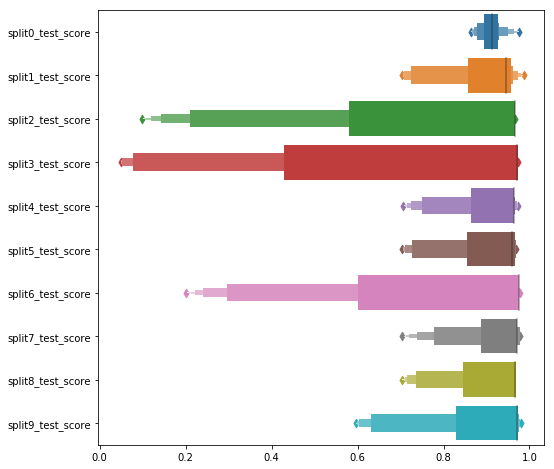

In [59]:
plt.figure(figsize = (8,8))
sns.boxenplot(data=extract_sk_cv(diff_pipe_cv), orient="h");